In [36]:
import importlib

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.utils import shuffle
import torch
import utils2
import model2
importlib.reload(utils2)
importlib.reload(model2)
from utils2 import *
from model2 import *
import copy

In [37]:
dataset_path = "Sketch-Icon-Dataset/"
icon_path = os.path.join(dataset_path, 'icon/')
sketch_path = os.path.join(dataset_path, 'sketch/')

icon_sketch_dic = get_dict_icon_sketches()
icon_sketch_dic_TRAIN = copy.deepcopy(icon_sketch_dic)
icon_sketch_dic_TEST = {}

NUM_TEST_SKETCHES = 1


for icon in icon_sketch_dic.keys():
    sketch_list = []
    for i in range(0, NUM_TEST_SKETCHES):
        sketch = np.random.choice(icon_sketch_dic[icon][1])
        sketch_list.append(sketch)
        icon_sketch_dic_TRAIN[icon][1].remove(sketch)
    icon_sketch_dic_TEST[icon] = (icon_sketch_dic[icon][0], sketch_list)


In [38]:
icon_name = np.random.choice(list(icon_sketch_dic_TEST.keys()))
test_sketch_name, category = np.random.choice(icon_sketch_dic_TEST[icon_name][1]), icon_sketch_dic_TEST[icon_name][0]
test_sketch_path = sketch_path + category + '/' + test_sketch_name
print(test_sketch_path)

Sketch-Icon-Dataset/sketch/construction/hammer_9.png


In [39]:
test_sketch = load_img(test_sketch_path)
test_sketch = np.expand_dims(test_sketch, 0)
test_sketch.shape

(1, 100, 100, 3)

In [40]:
test_icons = []
test_icon_paths = []
for icon, (category,_) in icon_sketch_dic_TEST.items():
    path = icon_path + category + '/' + icon
    test_icons.append(load_img(path))
    test_icon_paths.append(path)
test_icons = np.array(test_icons)
test_icons.shape

(100, 100, 100, 3)

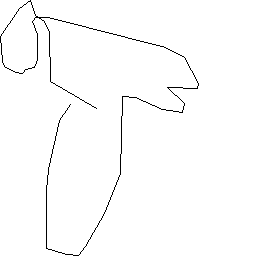

In [41]:
from PIL import Image
Image.open(test_sketch_path)

In [42]:
num_epochs = 10000
BATCH_SIZE = 128
margin = 1
optimizer = tf.keras.optimizers.Adam(0.0001)
tf.keras.backend.set_floatx('float64')
siameseModel = mynet()
loss = siamese_loss

def train_step( icons, sketches , labels, margin):
    with tf.GradientTape() as tape:
        model1 = siameseModel(icons)
        model2 = siameseModel(sketches)    
        tape.watch(model1)
        tape.watch(model2)
        labels = tf.convert_to_tensor(labels, dtype=tf.float64)
        tape.watch(labels)
        #current_loss = loss(model1, model2, labels, margin)
        current_loss = loss(model1, model2, labels)
    grads = tape.gradient(current_loss, siameseModel.trainable_variables)
    optimizer.apply_gradients(zip(grads, siameseModel.trainable_variables))
    return current_loss

In [43]:
#weights = []
for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    i, s, labels = get_batch(icon_sketch_dic_TRAIN, BATCH_SIZE)
    loss_value = train_step(i, s, labels, margin)
    epoch_loss_avg.update_state(loss_value)

    print("Epoch {:d}: Loss: {:.3f}".format(epoch,epoch_loss_avg.result()))
    #weights.append(siameseModel.trainable_variables)
    if epoch%5==0:
    
        sketch_repr = siameseModel(test_sketch)
        print(sketch_repr.shape)
        sketch_representations = np.tile(sketch_repr, len(test_icons)).reshape(len(test_icons), 64)
        print(sketch_representations.shape)
        
        icon_representations = []
        for i in range(len(test_icons)):
            icon_repr =  siameseModel(np.expand_dims(test_icons[i], 0))
            icon_representations.append(icon_repr)
        icon_representations = np.vstack(icon_representations)

        diff = np.sqrt(np.mean((sketch_representations - icon_representations)**2, -1))
        
        top_k = np.argsort(diff)[:20]
        #print ('##' + str(epoch) + ' : loss == ' + str(loss_))

        plt.figure(figsize=(20, 20))
        for i in range(20):    
            img = mpimg.imread(test_icon_paths[top_k[i]])
            plt.subplot(1, 20, i+1)
            plt.imshow(img)
            plt.xticks([])
            plt.yticks([])
        plt.show()

TypeError: siamese_loss() takes 3 positional arguments but 4 were given